<a href="https://colab.research.google.com/github/brunograssano/TP-Organizacion-de-datos/blob/main/TP_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico: Analisis Exploratorio - Organizacion de Datos

## Introduccion

Explicacion

## Objetivos

El objetivo del notebook es:
*   Entender los datos
*   Ver como los datos se relacionan entre si
*   Poder sacar alguna conclusión o descubrir un patrón a partir de estos
*   Indicar cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.




## Configuraciones Iniciales

Primero cargamos las bibliotecas que se van a ir usando a lo largo del trabajo, y realizamos la configuracion para los graficos que armemos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Carga y limpieza del set de datos

Cargamos ambos Datasets y vemos de dejarlos listos para comenzar el trabajo

In [ ]:
usuario_volveria_df = pd.read_csv('gdrive/My Drive/Datos/tp-2020-2c-train-cols1.csv')
usuario_volveria_df.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [ ]:
info_fiumark_df = pd.read_csv('gdrive/My Drive/Datos/tp-2020-2c-train-cols2.csv')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


Analizamos primero los tipos de datos que tienen ambos dataframes con el objetivo de poder convertirlos a otros que puedan llegar a ser mas utiles.

In [ ]:
usuario_volveria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_usuario  801 non-null    int64
 1   volveria    801 non-null    int64
dtypes: int64(2)
memory usage: 12.6 KB


Notamos que la columna de 'volveria' es de tipo int64, cuando solamente tiene valores que pueden ser 0 o 1. Un mejor tipo de dato para este caso puede ser un int8. Esto permitiria ahorrar memoria. (Aunque en este caso no sean muchos datos)

In [ ]:
usuario_volveria_df['volveria'] = usuario_volveria_df['volveria'].astype(np.int8)

Observamos en la informacion del dataframe que hay 801 registros y que para este caso no se encuentran valores nulos

Veamos ahora el otro dataframe. Este dataframe contiene la informacion respecto de las personas. 

In [ ]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tipo_de_sala   801 non-null    object 
 1   nombre         801 non-null    object 
 2   id_usuario     801 non-null    int64  
 3   genero         801 non-null    object 
 4   edad           641 non-null    float64
 5   amigos         801 non-null    int64  
 6   parientes      801 non-null    int64  
 7   id_ticket      801 non-null    object 
 8   precio_ticket  801 non-null    int64  
 9   fila           177 non-null    object 
 10  nombre_sede    799 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 69.0+ KB


Notamos una gran cantidad de valores nulos en la columna "fila" y algunos en "edad" y "nombre_sede". Como las columnas que tienen los valores nulos pueden llegar a ser relevantes para el analisis, siendo este el caso de las columnas "fila" y "edad" decidimos crear la categoria "No responde" para el caso de "fila".

In [ ]:
info_fiumark_df['fila'].fillna("No responde",inplace=True)

Ahora vemos la cantidad de valores unicos para las columnas de tipo objeto, para poder determinar a cuales les corresponderia tener un tipo categorico.

In [ ]:
info_fiumark_df.select_dtypes(include=['object']).nunique()

tipo_de_sala      3
nombre          801
genero            2
id_ticket       635
fila              3
nombre_sede       3
dtype: int64

In [ ]:
info_fiumark_df["tipo_de_sala"] = info_fiumark_df["tipo_de_sala"].astype("category")
info_fiumark_df["genero"] = info_fiumark_df["genero"].astype("category")
info_fiumark_df["nombre_sede"] = info_fiumark_df["nombre_sede"].astype("category")
info_fiumark_df["fila"] = info_fiumark_df["fila"].astype("category")


Otra cosa que observamos que las edades estan en formato de float, lo cual nos resulto llamativo, por lo que decidimos cortar los valores, llevandolos al piso.

In [ ]:
info_fiumark_df['edad'] = info_fiumark_df['edad'].apply(np.floor) 
#info_fiumark_df['edad'] = info_fiumark_df['edad'].astype(np.int) # VER QUE HACEMOS CON LOS VALORES NULOS, PREGUNTAR SI ES VALIDO TOMAR EL 3er CUANTIL POR LA EDAD

Tambien observamos que entre los datos que nos fueron entregados se encuentra el codigo de ticket: "id_ticket". Consideramos
que la informacion en ella es irrelevante para nuestros propositos y por lo tanto la eliminamos. Esta decision se debe a que parece que el codigo del ticket tiene forma de ser generada de forma aleatoria y no da la impresion de estar relacionada con la variable de interes para el analisis.

In [ ]:
info_fiumark_df.drop(columns='id_ticket',inplace=True)

Habiendo hecho esos cambios, finalmente nos queda el dataframe de la siguiente forma. En el proceso se redujo el uso de memoria, pasando de 69.0KB a 41.2KB.

In [ ]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tipo_de_sala   801 non-null    category
 1   nombre         801 non-null    object  
 2   id_usuario     801 non-null    int64   
 3   genero         801 non-null    category
 4   edad           641 non-null    float64 
 5   amigos         801 non-null    int64   
 6   parientes      801 non-null    int64   
 7   precio_ticket  801 non-null    int64   
 8   fila           801 non-null    category
 9   nombre_sede    799 non-null    category
dtypes: category(4), float64(1), int64(4), object(1)
memory usage: 41.2+ KB


In [ ]:
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,1,No responde,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,2,No responde,fiumark_palermo


Por ultimo, dejamos unidos ambos dataframes.

In [ ]:
info_fiumark_df = info_fiumark_df.merge(usuario_volveria_df,on='id_usuario')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,volveria
0,4d,Señor Camilo Pedro,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes,0
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes,0
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita,0
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,1,No responde,fiumark_palermo,0
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,2,No responde,fiumark_palermo,1


In [ ]:
#Explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados. 
#La empresa quiere saber cómo entender cada uno de los datos, cómo se relacionan entre sí
#Si se puede sacar alguna conclusión o descubrir un patrón a partir de estos. 
#Adicionalmente quieren saber cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.

## Analisis exploratorio

Empecemos el analisis haciendonos algunas preguntas sencillas.  
* ¿Es el genero una variable determinante a la hora de decidir ver la secuela?
*
*
*
*
*
*
*

In [ ]:
#¿Cuáles fueron las preguntas que se plantearon inicialmente?
#¿Qué se hizo para responder a esas preguntas?
#De los gráficos y análisis hechos, ¿qué conclusiones se pueden sacar?
#A partir del trabajo en los anteriores puntos, ¿surgieron nuevas dudas? -> Volver al paso 2
#A partir de todo el análisis anterior, construir el código baseline que se va a usar para la primera ronda de campaña digital. Fundamentar el código basándose en las conclusiones de los anteriores puntos.

### ¿Cuanto afecta el genero a la hora de ir a ver la siguiente pelicula?

Vemos que proporcion de los hombres y mujeres que fueron a ver la pelicula volverian a ver la secuela. Esto se puede obtener de forma sencilla.

A priori esperamos que la proporcion de mujeres que deciden ir a ver la secuela sea mucho mayor que la de los hombres que fueron a ver la pelicula.

In [ ]:
porcentaje_generos_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
porcentaje_generos_volveria.round(2)

genero
hombre    0.18
mujer     0.74
Name: volveria, dtype: float64

Habiendo hecho el calculo, en los numeros se ve claramente lo esperado.

Text(0.5, 0, 'Genero')

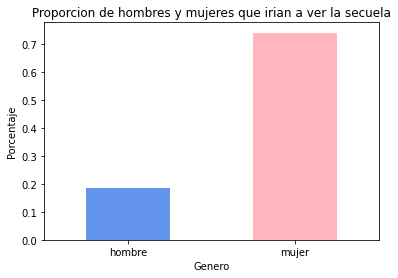

In [ ]:
porcentaje_generos_volveria.plot(kind = 'bar',rot = 0, color = ['cornflowerblue','lightpink'], title = 'Proporcion de hombres y mujeres que irian a ver la secuela')
ax = plt.gca()
ax.set_ylabel("Porcentaje")
ax.set_xlabel("Genero")